In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('ab_browser_test.csv')

In [3]:
df.shape

(566134, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566134 entries, 0 to 566133
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   userID            566134 non-null  int64 
 1   browser           566134 non-null  object
 2   slot              566134 non-null  object
 3   n_clicks          566134 non-null  int64 
 4   n_queries         566134 non-null  int64 
 5   n_nonclk_queries  566134 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 25.9+ MB


In [5]:
df.describe()

,userID,n_clicks,n_queries,n_nonclk_queries
count,566134.000000,566134.000000,566134.000000,566134.000000
mean,301377.214027,11.431658,10.720524,4.703987
std,175526.333101,20.251494,16.262827,8.109958
min,1.000000,0.000000,1.000000,0.000000
25%,148627.250000,1.000000,2.000000,1.000000
50%,299362.500000,4.000000,5.000000,2.000000
75%,455698.750000,13.000000,13.000000,6.000000
max,603137.000000,863.000000,665.000000,581.000000


In [6]:
df.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [7]:
exp = df[df['slot']=='exp']
control = df[df['slot']=='control']

In [39]:
100*(exp['n_clicks'].sum()/ control['n_clicks'].sum())

101.61356898244158

In [40]:
100*(sum(exp.n_clicks) - sum(control.n_clicks))/sum(control.n_clicks)

1.6135689824415806

In [41]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), size=(n_samples, len(data)))

    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [42]:
np.random.seed(0)

exp_med_scores = list(map(np.median, get_bootstrap_samples(np.array(exp['n_clicks']), 1000)))
control_med_scores = list(map(np.median, get_bootstrap_samples(np.array(control['n_clicks']), 1000)))

delta_median_scores = list(map(lambda x: x[0] - x[1], zip(exp_med_scores, control_med_scores)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [1. 1.]


In [43]:
exp_mean_scores = list(map(np.mean, get_bootstrap_samples(np.array(exp['n_clicks']), 1000)))
control_mean_scores = list(map(np.mean, get_bootstrap_samples(np.array(control['n_clicks']), 1000)))

delta_median_scores = list(map(lambda x: x[0] - x[1], zip(exp_mean_scores, control_mean_scores)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [0.19866114 0.40975645]


<AxesSubplot:ylabel='Frequency'>

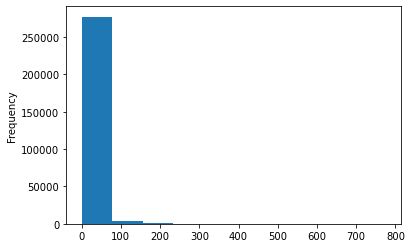

In [44]:
exp['n_clicks'].plot(kind='hist')

In [45]:
np.random.seed(0)
n_boot_samples = 500
samples = get_bootstrap_samples(np.array(control['n_clicks']), n_boot_samples)
control_mean_scores= list(map(np.mean, samples))

control_boot_chi_squared = list(map(lambda x: sum((x[0] - x[1])**2), zip(samples,control_mean_scores))) 

In [46]:
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

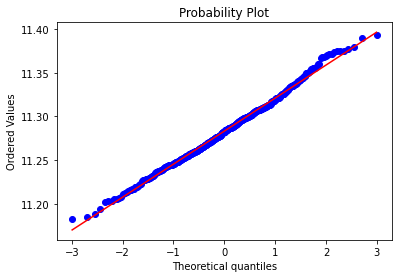

In [47]:
(osm, osr), (slope, intercept, r) = stats.probplot(control_mean_scores, dist="norm", plot=plt)

In [48]:
print('R squared: ', r**2)

R squared:  0.995953774208204


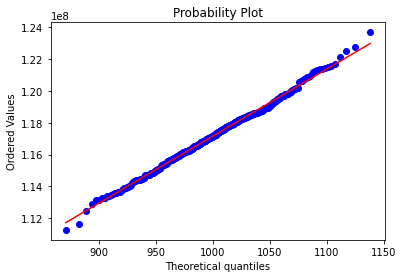

In [49]:
(osm, osr), (slope, intercept, r) = stats.probplot(control_boot_chi_squared, dist="chi2", 
                     sparams=(1000-1), plot=plt)

In [50]:
print('R squared: ', r**2)

R squared:  0.997210856910331


In [51]:
exp_user = exp.groupby(by='userID', )['n_clicks'].agg(np.sum)
control_user = control.groupby(by='userID' )['n_clicks'].agg(np.sum)

In [61]:
stats.mannwhitneyu(exp_user, control_user)

MannwhitneyuResult(statistic=41140868471.0, pvalue=8.694294377520879e-75)

In [65]:
df.browser.unique()

array(['Browser #2', 'Browser #4', 'Browser #14', 'Browser #17',
       'Browser #20', 'Browser #22'], dtype=object)

In [67]:
from statsmodels.stats.multitest import multipletests

In [70]:
browsers = ['Browser #2', 'Browser #4', 'Browser #14', 'Browser #17',
       'Browser #20', 'Browser #22']
for b in browsers:
    s, p = stats.mannwhitneyu(exp[exp['browser']==b]['n_clicks'], control[control['browser']==b]['n_clicks'])
    reject, p_corrected, a1, a2 = multipletests(p, alpha = 0.05, method = 'bonferroni')
    print(reject[0], p, p_corrected[0])

False 0.0544877208394482 0.0544877208394482
False 0.8152123531690997 0.8152123531690997
True 0.0 0.0
False 0.07480120286021603 0.07480120286021603
False 0.9073331277747075 0.9073331277747075
False 0.5148110304420064 0.5148110304420064
